#### step 1

Install tensorflow version 2 or higher

In [19]:
# !pip install -U --pre tensorflow=="2.*"

#### step 2

install pycocotools for coco detection API.

In [20]:
# !pip install pycocotools

#### step 3

get tensorflow/models by cloning the repository.

In [1]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  62% (2312/3696)
Updating files:  63% (2329/3696)
Updating files:  64% (2366/3696)
Updating files:  65% (2403/3696)
Updating files:  66% (2440/3696)
Updating files:  67% (2477/3696)
Updating files:  68% (2514/3696)
Updating files:  69% (2551/3696)
Updating files:  70% (2588/3696)
Updating files:  71% (2625/3696)
Updating files:  72% (2662/3696)
Updating files:  73% (2699/3696)
Updating files:  74% (2736/3696)
Updating files:  75% (2772/3696)
Updating files:  76% (2809/3696)
Updating files:  77% (2846/3696)
Updating files:  78% (2883/3696)
Updating files:  79% (2920/3696)
Updating files:  80% (2957/3696)
Updating files:  81% (2994/3696)
Updating files:  82% (3031/3696)
Updating files:  83% (3068/3696)
Updating files:  84% (3105/3696)
Updating files:  85% (3142/3696)
Updating files:  86% (3179/3696)
Updating files:  87% (3216/3696)
Updating files:  88% (3253/3696)
Updating files:  89% (3290/3696)
Updating files:  90% (3327/3696)
Updating files:  9

#### move (cd) to research directory of the repo

In [2]:
cd models/research

C:\Users\varsha\Untitled Folder\Computer Vision\Object Detection\Object Detection_SSD\models\research


#### step 4

compile protobufs

In [5]:
!protoc object_detection/protos/*.proto --python_out=.

install object_detection python package

In [21]:
# !pip install object_detection

#### step 5

import required libraries

In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

#### install tf_slim python package:

In [22]:
# !pip install tf_slim

#### import object detection modules:

In [8]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

#### step 6

function to load your model

In [9]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

 #### Label maps map indices to category names/Class names

In [23]:
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [27]:
# PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')

# Here I'm using custom random image for prediction

TEST_IMAGE_PATHS = r"C:\Users\varsha\Pictures\CV_IMG\desk.jpg"
# Image.open(TEST_IMAGE_PATHS)

#### step 7

load your object detection SSD mobilenet v1 model for object detection

In [29]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76534733/76534733 [==============================] - 33s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [30]:
# print(detection_model.inputs)
detection_model.output_dtypes

{'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32,
 'detection_scores': tf.float32}

In [31]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]

    output_dict = model(input_tensor)
    num_detections = int(output_dict.pop('num_detections'))

    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])     
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [32]:
def show_inference(model, image_path):

    img= Image.open(image_path)

    image_np = np.array(Image.open(image_path))

    output_dict = run_inference_for_single_image(model, image_np)

    boxes = []
    classes = []
    scores = []
    
    # Visualize the detection boxes and labels on the image
    plt.figure(figsize=(12, 8))
    
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
    
    plt.imshow(image_np)
    plt.show()

    display(Image.fromarray(image_np))

C:\Users\varsha\AppData\Local\Temp\ipykernel_23928\1545408164.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


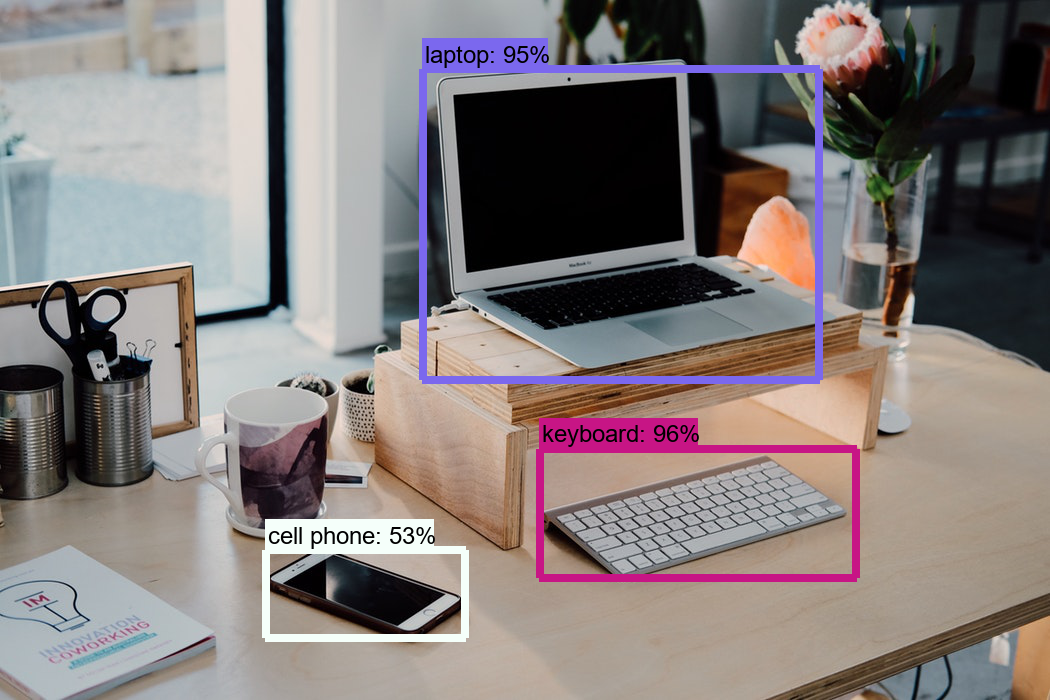

In [33]:
# for image_path in TEST_IMAGE_PATHS:
show_inference(detection_model, TEST_IMAGE_PATHS)